# Rowing Classfier

## This projects aims to classify images of rowing boats into their respective boat classes.

Let's import the modules we need - we'll use the ResNet50 model as the base of our model. It's been trained on the ImageNet dataset to detect and classify 1,000 objects. 

In [1]:
import keras
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D

Using TensorFlow backend.


Let's have a quick look at the images:

In [2]:
import os

number_images = []
folder = 'all_rowing_images'
for boat in ['Doubles', 'Eights', 'Fours', 'Pairs', 'Quads', 'Singles']:
    num = len(os.listdir(folder+ '\\' + boat))
    number_images.append(num)
    print('Number of Images in {}: {}'.format(boat, num) )

print('\n')
target_number = min(number_images)
print('Minimum number of images is {}'.format(target_number))

Number of Images in Doubles: 239
Number of Images in Eights: 867
Number of Images in Fours: 0
Number of Images in Pairs: 132
Number of Images in Quads: 647
Number of Images in Singles: 89


Minimum number of images is 0


(400, 600, 3)


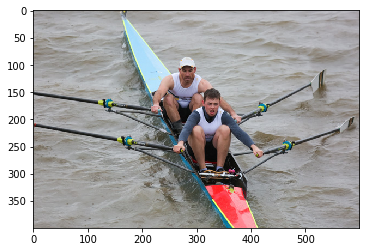

In [35]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

sample_image_path = os.listdir('all_rowing_images/Doubles')[0]
path = 'all_rowing_images/Doubles/' + sample_image_path
sample_image = cv2.imread(path)

print(sample_image.shape)

RGB_img = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img)

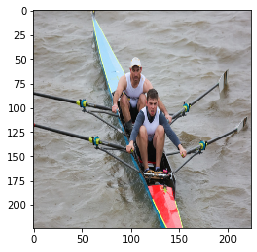

In [36]:
resized_img = cv2.resize(sample_image, (224, 224))
colour_resized = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
plt.imshow(colour_resized)

So now we can see that there is a lot more images in some classes compared to others. We'd want to train on the same number of images in all categories so there is less bias. Also we see that the images are 400x600, but we can take care of that later. 
For now, let's create a new training directory called 'train_images' that has the same number of images in each category. 

In [5]:
import shutil
from random import shuffle

for boat in ['Doubles', 'Eights', 'Fours', 'Pairs', 'Quads', 'Singles']:
    os.makedirs('train_images/' + boat)
    os.makedirs('val_images/' + boat)
    
    image_list = os.listdir('all_rowing_images/' + boat)
    copied_list = [img for img in image_list]
    shuffle(copied_list)
    
    training = copied_list[:250]
    validation = copied_list[250:306]
           
    for index, path in enumerate(training, 1): 
        image_path = 'all_rowing_images/' + boat + '//' + path
        shutil.move(image_path, 'train_images/'+boat+'//'+str(index)+'.jpg')
        
    for index, path in enumerate(validation, 1): 
        image_path = 'all_rowing_images/' + boat + '//' + path
        shutil.move(image_path, 'val_images/'+boat+'//'+str(index)+'.jpg')
       
        
print(len(os.listdir('train_images/Doubles')))    

250


Now all the categories have exactly 306 images each, hopefully enough to train our model. The next step is to preprocess our images so we're ready to pass them to the model. We can do that using some functions built into keras

In [21]:
#for training dataset
aug_datagen = ImageDataGenerator(rescale = 1./255)

#for testing data set
val_datagen = ImageDataGenerator(rescale = 1./255)

In [22]:
batch_size = 128
train_generator = aug_datagen.flow_from_directory('train_images',
                                                 target_size=(224, 224),
                                                 batch_size=batch_size,
                                                 class_mode='categorical'
                                                 )

val_generator = val_datagen.flow_from_directory('val_images',
                                                 target_size=(224, 224),
                                                 class_mode='categorical'
                                                 )


Found 1500 images belonging to 6 classes.
Found 336 images belonging to 6 classes.


Next we want to define the model

## The Model

Here we will be using the pre training Resnet50 model from keras

In [9]:
num_classes = 6

base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))

model.layers[0].trainable = False #we'll use the pretrained weights for now

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 3078      
Total params: 14,717,766
Trainable params: 3,078
Non-trainable params: 14,714,688
_________________________________________________________________


In [10]:
model.compile(optimizer='adam',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])

In [11]:
history = model.fit_generator(train_generator,
                    epochs = 20,
                    steps_per_epoch = 1500//batch_size,
                    validation_data = val_generator,
                    validation_steps = 336/batch_size,
                    workers=3,
                    )

Epoch 1/20
11/11 [==============================] - 271s 25s/step - loss: 2.0988 - acc: 0.1733 - val_loss: 1.8358 - val_acc: 0.1562
Epoch 2/20
11/11 [==============================] - 262s 24s/step - loss: 1.8212 - acc: 0.1839 - val_loss: 1.7395 - val_acc: 0.2708
Epoch 3/20
11/11 [==============================] - 258s 23s/step - loss: 1.7291 - acc: 0.2758 - val_loss: 1.6651 - val_acc: 0.5000
Epoch 4/20
11/11 [==============================] - 252s 23s/step - loss: 1.6707 - acc: 0.3410 - val_loss: 1.5975 - val_acc: 0.5125
Epoch 5/20
11/11 [==============================] - 270s 25s/step - loss: 1.6189 - acc: 0.3874 - val_loss: 1.5709 - val_acc: 0.5104
Epoch 6/20
11/11 [==============================] - 268s 24s/step - loss: 1.5744 - acc: 0.4018 - val_loss: 1.5437 - val_acc: 0.5104
Epoch 7/20
11/11 [==============================] - 267s 24s/step - loss: 1.5553 - acc: 0.4328 - val_loss: 1.5160 - val_acc: 0.5312
Epoch 8/20
11/11 [==============================] - 274s 25s/step - loss: 1.

In [12]:
history = model.fit_generator(train_generator,
                    epochs = 20,
                    steps_per_epoch = 1500//batch_size,
                    validation_data = val_generator,
                    validation_steps = 336/batch_size,
                    workers=3,
                    )

Epoch 1/20
11/11 [==============================] - 286s 26s/step - loss: 1.2098 - acc: 0.5877 - val_loss: 1.1845 - val_acc: 0.6146
Epoch 2/20
11/11 [==============================] - 267s 24s/step - loss: 1.1685 - acc: 0.6120 - val_loss: 1.2055 - val_acc: 0.5875
Epoch 3/20
11/11 [==============================] - 272s 25s/step - loss: 1.1559 - acc: 0.6092 - val_loss: 1.1402 - val_acc: 0.5938
Epoch 4/20
11/11 [==============================] - 273s 25s/step - loss: 1.1494 - acc: 0.6158 - val_loss: 1.1236 - val_acc: 0.6667
Epoch 5/20
11/11 [==============================] - 267s 24s/step - loss: 1.1313 - acc: 0.6284 - val_loss: 1.0947 - val_acc: 0.6875
Epoch 6/20
11/11 [==============================] - 266s 24s/step - loss: 1.1234 - acc: 0.6262 - val_loss: 1.1958 - val_acc: 0.5500
Epoch 7/20
11/11 [==============================] - 274s 25s/step - loss: 1.0968 - acc: 0.6335 - val_loss: 1.0893 - val_acc: 0.6875
Epoch 8/20
11/11 [==============================] - 264s 24s/step - loss: 1.

In [13]:
history = model.fit_generator(train_generator,
                    epochs = 20,
                    steps_per_epoch = 1500//batch_size,
                    validation_data = val_generator,
                    validation_steps = 336/batch_size,
                    workers=3,
                    )

Epoch 1/20
11/11 [==============================] - 234s 21s/step - loss: 0.9726 - acc: 0.6688 - val_loss: 0.9461 - val_acc: 0.6875
Epoch 2/20
11/11 [==============================] - 255s 23s/step - loss: 0.9630 - acc: 0.6766 - val_loss: 0.9123 - val_acc: 0.7500
Epoch 3/20
11/11 [==============================] - 266s 24s/step - loss: 0.9580 - acc: 0.6998 - val_loss: 0.9730 - val_acc: 0.6979
Epoch 4/20
11/11 [==============================] - 264s 24s/step - loss: 0.9407 - acc: 0.6988 - val_loss: 0.9108 - val_acc: 0.7875
Epoch 5/20
11/11 [==============================] - 278s 25s/step - loss: 0.9440 - acc: 0.6938 - val_loss: 0.9277 - val_acc: 0.7083
Epoch 6/20
11/11 [==============================] - 278s 25s/step - loss: 0.9307 - acc: 0.6914 - val_loss: 0.8890 - val_acc: 0.7708
Epoch 7/20
11/11 [==============================] - 297s 27s/step - loss: 0.9338 - acc: 0.6918 - val_loss: 0.8959 - val_acc: 0.7604
Epoch 8/20
11/11 [==============================] - 265s 24s/step - loss: 0.

In [15]:
import h5py
#save model so we can continue training
model.save('model_300919.h5')

In [16]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

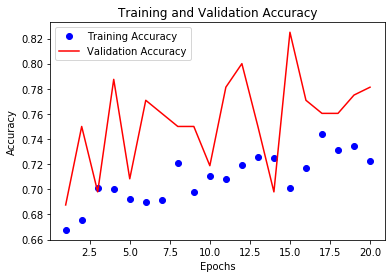

In [20]:
test_acc = history.history['acc']
val_acc = history.history['val_acc']
test_loss = history.history['loss']
val_loss = history.history['val_loss']

%matplotlib inline 
import matplotlib.pyplot as plt

epochs = range(1, len(test_acc)+1)
plt.plot(epochs, test_acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [4]:
from keras.models import load_model

model = load_model('model_300919.h5')

W1001 18:39:09.932708 31268 deprecation_wrapper.py:119] From C:\Users\md705\Anaconda3\envs\rowing\lib\site-packages\keras\backend\tensorflow_backend.py:4070: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W1001 18:39:11.707290 31268 deprecation_wrapper.py:119] From C:\Users\md705\Anaconda3\envs\rowing\lib\site-packages\keras\backend\tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.

C:\Users\md705\Anaconda3\envs\rowing\lib\site-packages\keras\engine\saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [6]:
model.layers[0].trainable = False
model.compile(optimizer='adam',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 3078      
Total params: 14,717,766
Trainable params: 3,078
Non-trainable params: 14,714,688
_________________________________________________________________


In [7]:
history = model.fit_generator(train_generator,
                    epochs = 20,
                    steps_per_epoch = 1500//batch_size,
                    validation_data = val_generator,
                    validation_steps = 336/batch_size,
                    workers=3,
                    )

Epoch 1/20
11/11 [==============================] - 242s 22s/step - loss: 0.8440 - accuracy: 0.7337 - val_loss: 0.9775 - val_accuracy: 0.7604
Epoch 2/20
11/11 [==============================] - 229s 21s/step - loss: 0.8367 - accuracy: 0.7365 - val_loss: 0.7427 - val_accuracy: 0.7812
Epoch 3/20
11/11 [==============================] - 232s 21s/step - loss: 0.8200 - accuracy: 0.7529 - val_loss: 0.7586 - val_accuracy: 0.7812
Epoch 4/20
11/11 [==============================] - 236s 21s/step - loss: 0.8202 - accuracy: 0.7372 - val_loss: 0.8037 - val_accuracy: 0.7875
Epoch 5/20
11/11 [==============================] - 233s 21s/step - loss: 0.8364 - accuracy: 0.7343 - val_loss: 0.8024 - val_accuracy: 0.8438
Epoch 6/20
11/11 [==============================] - 245s 22s/step - loss: 0.7886 - accuracy: 0.7573 - val_loss: 0.8107 - val_accuracy: 0.7604
Epoch 7/20
11/11 [==============================] - 255s 23s/step - loss: 0.8158 - accuracy: 0.7427 - val_loss: 0.8292 - val_accuracy: 0.7396
Epoch 

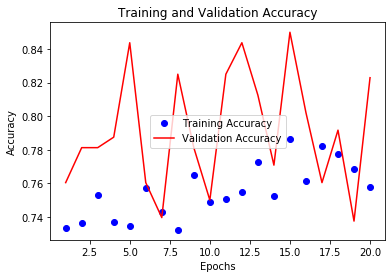

In [11]:
test_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
test_loss = history.history['loss']
val_loss = history.history['val_loss']

import matplotlib.pyplot as plt
%matplotlib inline

epochs = range(1, len(test_acc)+1)
plt.plot(epochs, test_acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [14]:
import numpy as np
acc = np.array(val_acc)
np.mean(acc)

0.7913541704416275

In [15]:
new_history = model.fit_generator(train_generator,
                    epochs = 20,
                    steps_per_epoch = 1500//batch_size,
                    validation_data = val_generator,
                    validation_steps = 336/batch_size,
                    workers=3,
                    )

Epoch 1/20
11/11 [==============================] - 234s 21s/step - loss: 0.7355 - accuracy: 0.7806 - val_loss: 0.7144 - val_accuracy: 0.7396
Epoch 2/20
11/11 [==============================] - 245s 22s/step - loss: 0.7320 - accuracy: 0.7699 - val_loss: 0.6948 - val_accuracy: 0.8438
Epoch 3/20
11/11 [==============================] - 249s 23s/step - loss: 0.7253 - accuracy: 0.7792 - val_loss: 0.7206 - val_accuracy: 0.8750
Epoch 4/20
11/11 [==============================] - 246s 22s/step - loss: 0.7089 - accuracy: 0.7799 - val_loss: 0.5072 - val_accuracy: 0.8250
Epoch 5/20
11/11 [==============================] - 271s 25s/step - loss: 0.7175 - accuracy: 0.7812 - val_loss: 0.6570 - val_accuracy: 0.7708
Epoch 6/20
11/11 [==============================] - 275s 25s/step - loss: 0.7421 - accuracy: 0.7560 - val_loss: 0.6376 - val_accuracy: 0.7604
Epoch 7/20
11/11 [==============================] - 272s 25s/step - loss: 0.7049 - accuracy: 0.7813 - val_loss: 0.6431 - val_accuracy: 0.8646
Epoch 

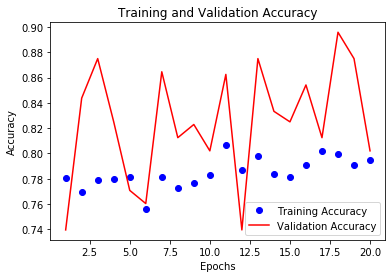

In [28]:
test_acc = new_history.history['accuracy']
val_acc = new_history.history['val_accuracy']
test_loss = new_history.history['loss']
val_loss = new_history.history['val_loss']

import matplotlib.pyplot as plt
%matplotlib inline

epochs = range(1, len(test_acc)+1)
plt.plot(epochs, test_acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [32]:
# time to try and predict 
import os
import cv2
from keras.preprocessing.image import img_to_array
import random

boat_type = random.choice(['Doubles', 'Eights', 'Pairs', 'Quads', 'Singles'])

sample_image_path = random.choice(os.listdir('all_rowing_images/{}'.format(boat_type)))
path = 'all_rowing_images/{}/'.format(boat_type) + sample_image_path
image = cv2.imread(path)
#resize to 224x224
resized_img = cv2.resize(image, (224, 224))
colour_resized = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)

img = img_to_array(colour_resized)
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
img = img/225.
prediction = model.predict(img)[0]
output, percent = map_to_classes(prediction)
print(boat_type, output, percent)

Quads Quads 0.7529824


In [24]:
def map_to_classes(array):
    l = list(array)
    classes = ['Doubles', 'Eights','Fours', 'Pairs', 'Quads', 'Singles']
    index = l.index(max(l))
    return classes[index], max(l)

In [3]:
def prep_image(img):
    #resize to 224x224
    resized_img = cv2.resize(image, (224, 224))
    colour_resized = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)

    img = img_to_array(colour_resized)
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
    img = img/225.
    return img

In [84]:
model.save('model_011019.h5')

In [10]:
from keras.models import load_model
model = load_model('model_011019.h5')
model.layers[0].trainable = False
model.compile(optimizer='adam',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])

C:\Users\md705\Anaconda3\envs\rowing\lib\site-packages\keras\engine\saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [44]:
def one_image():
    boat_type = random.choice(['Doubles', 'Eights', 'Pairs', 'Quads', 'Singles'])

    sample_image_path = random.choice(os.listdir('all_rowing_images/{}'.format(boat_type)))
    path = 'all_rowing_images/{}/'.format(boat_type) + sample_image_path
    image = cv2.imread(path)
    #resize to 224x224
    resized_img = cv2.resize(image, (224, 224))
    colour_resized = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)

    img = img_to_array(colour_resized)
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
    img = img/225.
    prediction = model.predict(img)[0]
    output, percent = map_to_classes(prediction)
    
    return boat_type == output

one_image()

True

In [46]:
# time to try and predict 
import os
import cv2
from keras.preprocessing.image import img_to_array
import random

def single_sim(n=100):

    num_right = 0
    for i in range(n):
        pred = one_image()
        if pred == True:
            num_right += 1
    return num_right
        

single_sim(100)

89

In [52]:
import numpy as np

def model_accuracy(n=100):
    all_acc = np.zeros(n)
    for i in range(n):
        percent = single_sim(100)
        print(i)
        all_acc[i] = percent
    #avg_acc = np.mean(all_acc)
    return np.mean(all_acc) 
    

In [53]:
simulated_accuracy = model_accuracy(100)
print(f"Average accuracy is {simulated_accuracy}")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Average accuracy is 85.47


In [54]:
simulated_accuracy

85.47